# Compare Models

This notebook compares various GFW models based on the `measure_speed` and `measure_course` with each other
and with the models from Dalhousie University.

# Compare Dal's purse seiner model with ours

Note that this doesn't include the distance to shore cutoff in either model.


In the `vessel-scoring` repo:

```
python scripts/make_ps_data_ready_for_dal.py
```

I disabled distshore in dal for the models that still have it using some hackery so that (a) it ran faster and (b) the comparisons were 'fair'.

Then in the `dal` repo:

```

# First, turned off distshore in the models that still have it using some hackery.

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_purse_seine.measures.from_npz.csv  ../vessel-scoring/dal_purse_seine_results.csv dalhouse/models/timeofday/

dal timothyhochberg$ Rscript dalhouse/models/trawler.R ../vessel-scoring/datasets/kristina_trawler.measures.from_npz.csv  ../vessel-scoring/dal_trawler_results.csv dalhouse/models/coastline/ data/training/trawl.csv 

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_longliner.measures.from_npz.csv  ../vessel-scoring/dal_longliner_results.csv dalhouse/models/timeofday/


```

In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics
import pandas as pd

In [2]:
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [3]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [4]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_pseine.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_pseine.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_pseine.dtype)

In [5]:
TRANSIT_WEIGHT = 10

xtrainmap = {'purse_seine': np.concatenate([xtrain_pseine, xcross_pseine] + [xtrain_tran] * TRANSIT_WEIGHT),
          'longliner': np.concatenate([xtrain_lline, xcross_lline] + [xtrain_tran] * TRANSIT_WEIGHT),
          'trawler': np.concatenate([xtrain_trawl, xcross_trawl] + [xtrain_tran] * TRANSIT_WEIGHT)}
          

xtestmap = {'purse_seine': xtest_pseine,
         'longliner': xtest_lline,
         'trawler': xtest_trawl}

In [6]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel

untrained_models = [
    ('Logistic', LogisticModel(colspec=dict(windows=[43200]), order=6)),
    ('Logistic (MW)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6)),
    ('Logistic (MW)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6)),
    ('Logistic (MW & daylight)', LogisticModel(
                                    colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                                 measures=['measure_daylight']), order=6)),
    # Using `speed` here rather than `measure_speed` gives terrible results. Overflow? Just way too large?
    ('Logistic (MW & daylight & speed)', LogisticModel(
                                    colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                                 measures=['measure_daylight', 'measure_speed']), order=6)),
    ('Random Forest', RandomForestModel(colspec=dict(windows=[43200]))),
    ('Random Forest (MW)', RandomForestModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]))),
    ('Random Forest (MW & daylight)', RandomForestModel
                                 (colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                               measures=['measure_daylight']))),
    ('Random Forest (MW & daylight & speed)', RandomForestModel
                                 (colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                               measures=['measure_daylight', 'speed']))),
]


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic|0.32|0.05|0.09|
|Logistic (MW & daylight & speed)|0.90|0.23|0.37|
|Logistic (MW & daylight)|0.90|0.21|0.35|
|Logistic (MW)|0.65|0.17|0.27|
|Random Forest|0.42|0.08|0.13|
|Random Forest (MW & daylight & speed)|0.88|0.28|0.42|
|Random Forest (MW & daylight)|0.88|0.25|0.38|
|Random Forest (MW)|0.73|0.18|0.29|
|dal|0.76|0.18|0.29|

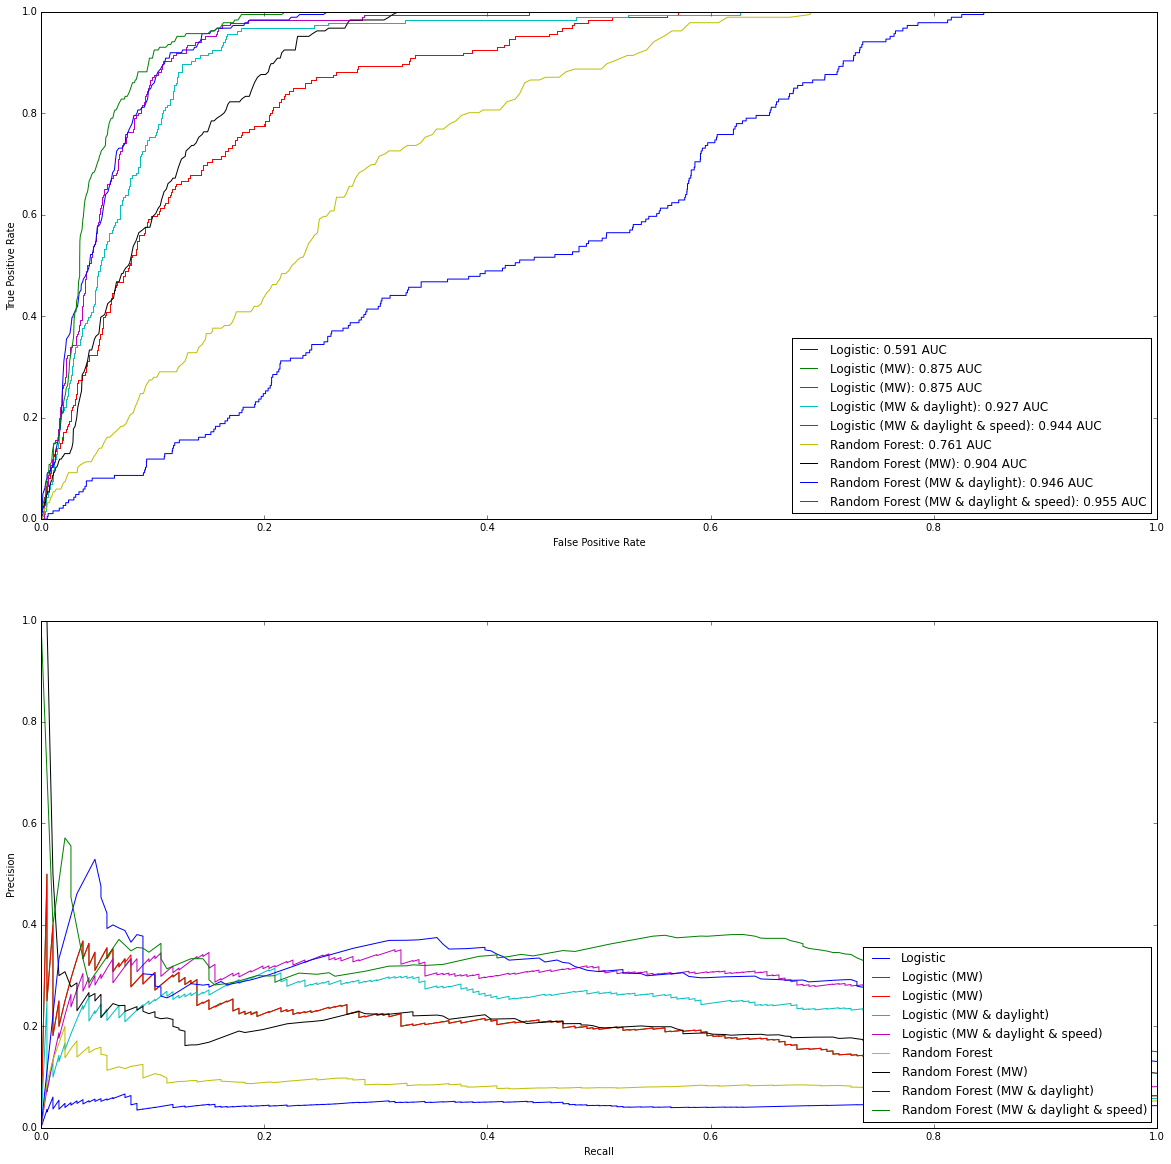

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic|0.83|0.90|0.87|
|Logistic (MW & daylight & speed)|0.90|0.95|0.92|
|Logistic (MW & daylight)|0.90|0.94|0.92|
|Logistic (MW)|0.90|0.94|0.92|
|Random Forest|0.88|0.90|0.89|
|Random Forest (MW & daylight & speed)|0.92|0.93|0.93|
|Random Forest (MW & daylight)|0.92|0.93|0.93|
|Random Forest (MW)|0.92|0.93|0.92|
|dal|0.74|0.97|0.84|

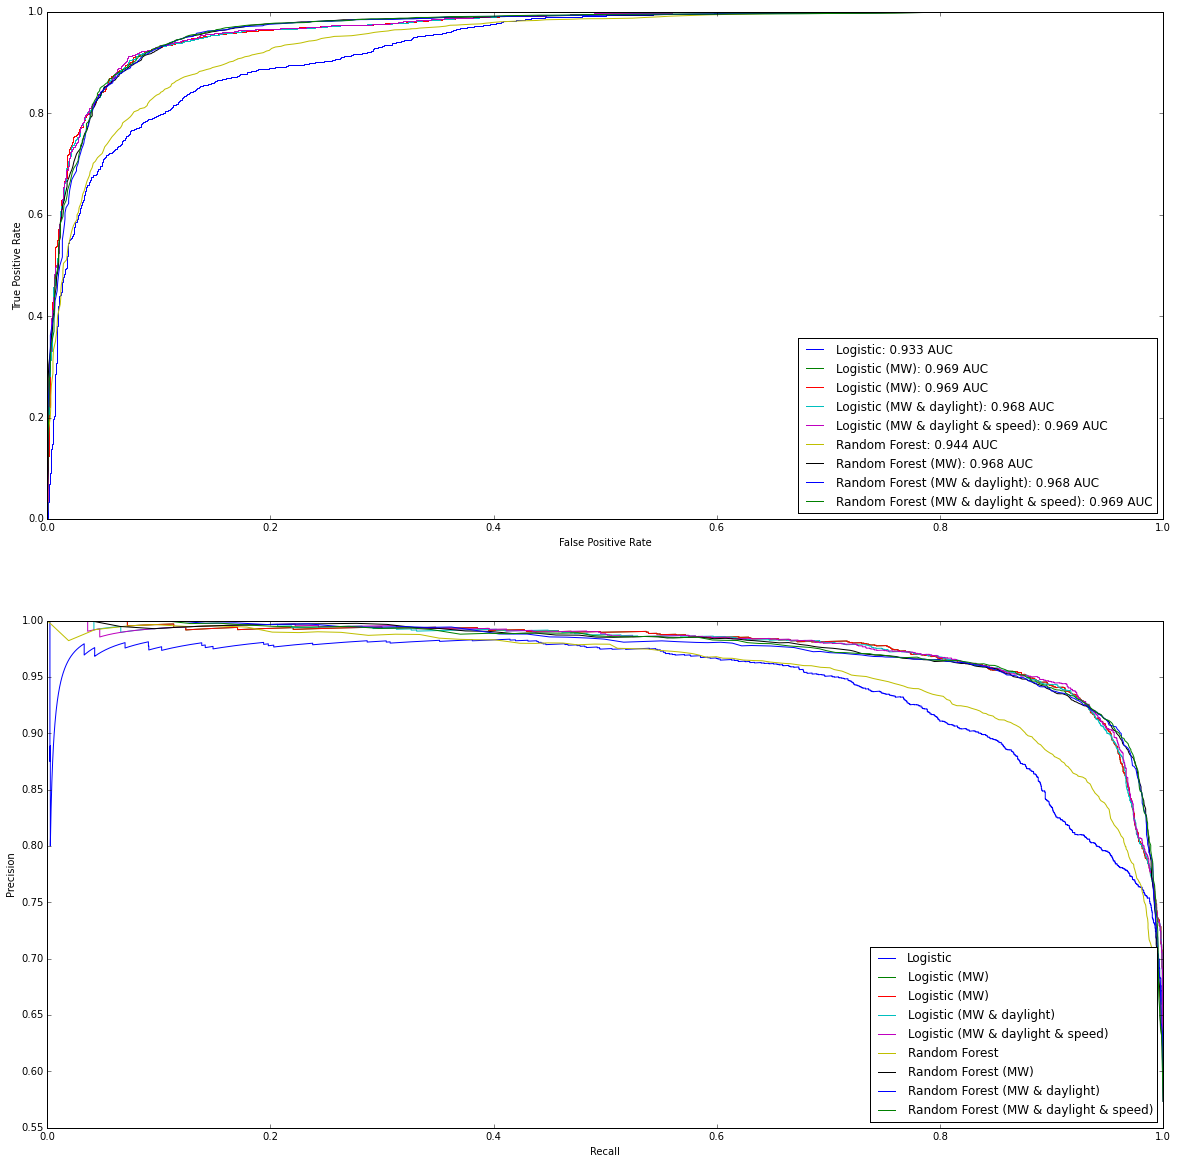

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic|0.80|0.95|0.87|
|Logistic (MW & daylight & speed)|0.90|0.96|0.93|
|Logistic (MW & daylight)|0.90|0.96|0.93|
|Logistic (MW)|0.90|0.97|0.93|
|Random Forest|0.88|0.96|0.92|
|Random Forest (MW & daylight & speed)|0.90|0.97|0.93|
|Random Forest (MW & daylight)|0.90|0.97|0.94|
|Random Forest (MW)|0.90|0.97|0.93|
|dal|0.73|0.93|0.82|

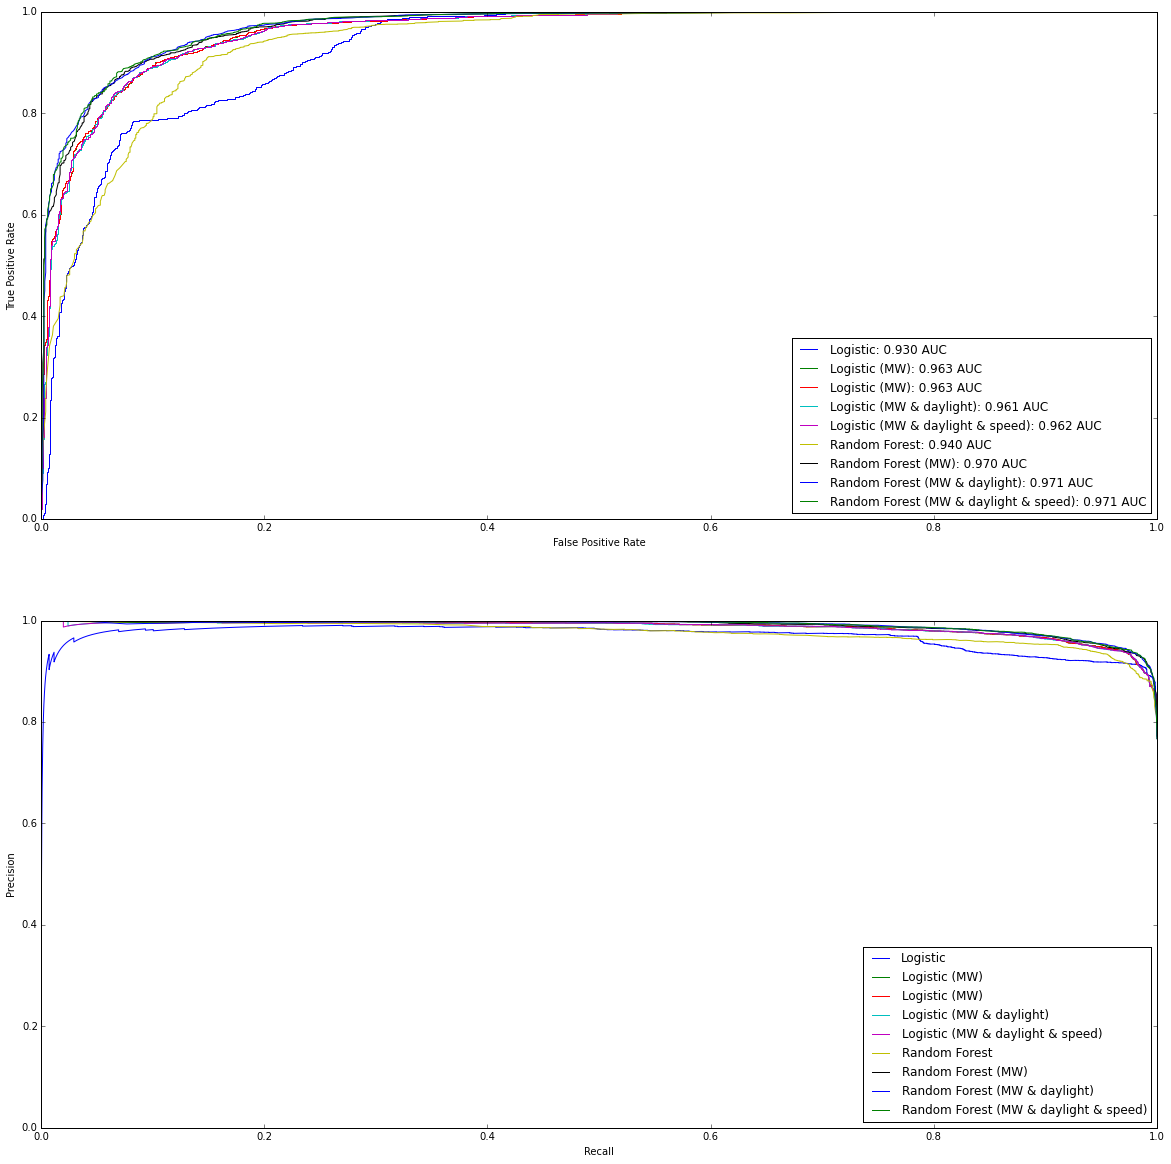

In [7]:

for gear in ['purse_seine', 'trawler', 'longliner']:
    xtest = xtestmap[gear]
    xtrain = xtrainmap[gear]
    test_mmsi = set(xtest['mmsi'])

    display(HTML("<h2>{}</h2>".format(gear.replace('-', ' ').title())))
    
    dal_res = pd.read_csv("dal_{}_results.csv".format(gear))
    mask = np.array([(x in test_mmsi) for x in dal_res['mmsi']]).astype(bool)
    predictions = {}

    trained_models = [(name, train_model_on_data(mdl, xtrain)) for (name, mdl) in untrained_models]
    for name, mdl in trained_models:
        
        predictions[name] = ((mdl.predict_proba(xtest)[:,1] > 0.5), xtest['classification'])

        predictions['dal'] = (dal_res.preds[mask], dal_res.classification[mask])
        # Fix predictions for Trawler.py
        predictions['dal'] = ([{'F': 1, 'N': 0}.get(x, x) for x in predictions['dal'][0]], predictions['dal'][1])

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name in sorted(predictions):
        pred, actual = predictions[name]
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, xtest)
    
    display(HTML("<hr/>"))